# Fama French Factors Model

## Names: Amanda Nguyen, Rudra Garg, Nevin Arimilli, Nicolay Huarancay


#### Modules

In [1]:
import wrds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error
import yfinance as yf
import matplotlib.pyplot as plt

#### Connection to WRDS
Using username and password

In [2]:
conn = wrds.Connection()

WRDS recommends setting up a .pgpass file.
You can create this file yourself at any time
with the create_pgpass_file() function.
Loading library list...
Done


***

## Data

### Monthly Market Equity and Close Prices

In [13]:
# Query: Market Equity @ each month
# ( Share Codes: 10 or 11 - Exchange Codes: 1,2,3 [NYSE, AMEX(NYSE MKT), and NASDAQ] )

df_sec_monthly = conn.raw_sql("""select a.gvkey, a.datadate, 
                                        cast(to_char(a.datadate,'YYYY') as int) as year,
                                        cast(to_char(a.datadate,'YYYY') as int) -1  as last_fyear,
                                        case when to_char(a.datadate,'MM') = '12' then
                                               concat(cast(cast(to_char(a.datadate,'YYYY') as int) + 1 as varchar),'01')
                                             else
                                               cast(cast(to_char(a.datadate,'YYYYMM') as int) + 1 as varchar)
                                        end as month,
                                        case when to_char(a.datadate,'MM') = '06' then 1 else 0 end as m_june,
                                        a.tic, a.conm,
                                        a.prccm, a.cshom/1000000 as cshom,
                                        a.prccm*a.cshom/1000000 as market_equity,
                                        a.dvpspm, a.dvpspm*a.cshom/1000000 as div_paid
                                   from comp.secm a
                                  inner join (select distinct ticker
                                                from crsp.stocknames
                                               where shrcd in (10,11)
                                                 and exchcd in (1,2,3)
                                                 and ticker is not null
                                                 and ticker not in ('NA')) b
                                      on a.tic = b.ticker
                                   """,
                               date_cols=['datadate'])

# Saving
df_sec_monthly.to_csv('01_df_sec_monthly.csv', index=False)

### Annual Book Equity and ME

In [14]:
# Query: Book to Market @ December
# ( Share Codes: 10 or 11 - Exchange Codes: 1,2,3 [NYSE, AMEX(NYSE MKT), and NASDAQ] )

df_bequity_dec = conn.raw_sql("""select a.gvkey, a.datadate, 
                                        a.fyear, a.datafmt,
                                        cast(to_char(a.datadate,'YYYY') as int) as year,
                                        a.tic, a.conm,
                                        a.prcc_f, a.csho, a.ceq,
                                        a.ceq as book_equity,
                                        a.prcc_f*a.csho as market_equity,
                                        case when a.prcc_f*a.csho > 0
                                             then a.ceq/(a.prcc_f*a.csho) end as book_to_market
                                   from comp.funda a 
                                  inner join (select distinct ticker
                                                from crsp.stocknames
                                               where shrcd in (10,11)
                                                 and exchcd in (1,2,3)
                                                 and ticker is not null
                                                 and ticker not in ('NA')) b
                                      on a.tic = b.ticker
                                where a.datafmt = 'STD'
                              """,
                              date_cols=['datadate'])

# Saving
df_bequity_dec.to_csv('02_df_bequity_dec.csv', index=False)

In [3]:
# Loading - Monthly
df_sec_monthly = pd.read_csv('01_df_sec_monthly.csv')
df_sec_monthly.head()

,gvkey,datadate,year,last_fyear,month,m_june,tic,conm,prccm,cshom,market_equity,dvpspm,div_paid
0,1003,1983-12-31,1983,1982,198401,0,ANTQ,A.A. IMPORTING CO INC,5.250,NaN,NaN,NaN,NaN
1,1003,1984-01-31,1984,1983,198402,0,ANTQ,A.A. IMPORTING CO INC,5.000,NaN,NaN,NaN,NaN
2,1003,1984-02-29,1984,1983,198403,0,ANTQ,A.A. IMPORTING CO INC,4.250,NaN,NaN,NaN,NaN
3,1003,1984-03-31,1984,1983,198404,0,ANTQ,A.A. IMPORTING CO INC,5.000,NaN,NaN,NaN,NaN
4,1003,1984-04-30,1984,1983,198405,0,ANTQ,A.A. IMPORTING CO INC,4.125,NaN,NaN,NaN,NaN


In [4]:
# Loading - Annual
df_bequity_dec = pd.read_csv('02_df_bequity_dec.csv')
df_bequity_dec.head()

,gvkey,datadate,fyear,datafmt,year,tic,conm,prcc_f,csho,ceq,book_equity,market_equity,book_to_market
0,1003,1980-12-31,1980.0,STD,1980,ANTQ,A.A. IMPORTING CO INC,NaN,NaN,NaN,NaN,NaN,NaN
1,1003,1981-12-31,1981.0,STD,1981,ANTQ,A.A. IMPORTING CO INC,NaN,NaN,NaN,NaN,NaN,NaN
2,1003,1982-12-31,1982.0,STD,1982,ANTQ,A.A. IMPORTING CO INC,NaN,2.100,1.983,1.983,NaN,NaN
3,1003,1983-12-31,1983.0,STD,1983,ANTQ,A.A. IMPORTING CO INC,5.25,2.683,6.095,6.095,14.08575,0.432707
4,1003,1984-12-31,1984.0,STD,1984,ANTQ,A.A. IMPORTING CO INC,2.75,2.683,6.482,6.482,7.37825,0.878528


## Portfolios 2x3: Merginig ME and BE/ME

In [5]:
# Loading
df_bequity_dec = pd.read_csv('02_df_bequity_dec.csv')
df_sec_monthly = pd.read_csv('01_df_sec_monthly.csv')
df_sec_june = df_sec_monthly[df_sec_monthly['m_june']==1]

In [6]:
# Put it together: ME and BE/ME
df_equity = df_sec_june.merge(df_bequity_dec[['tic','year','book_equity','book_to_market']], 
                              left_on = ['tic','last_fyear'], right_on = ['tic','year'])
df_equity.head()

,gvkey,datadate,year_x,last_fyear,month,m_june,tic,conm,prccm,cshom,market_equity,dvpspm,div_paid,year_y,book_equity,book_to_market
0,1003,1984-06-30,1984,1983,198407,1,ANTQ,A.A. IMPORTING CO INC,4.00,NaN,NaN,NaN,NaN,1983,6.095,0.432707
1,1003,1985-06-30,1985,1984,198507,1,ANTQ,A.A. IMPORTING CO INC,3.50,NaN,NaN,NaN,NaN,1984,6.482,0.878528
2,1003,1987-06-30,1987,1986,198707,1,ANTQ,A.A. IMPORTING CO INC,4.50,NaN,NaN,NaN,NaN,1986,6.665,0.552035
3,1003,1988-06-30,1988,1987,198807,1,ANTQ,A.A. IMPORTING CO INC,3.75,NaN,NaN,NaN,NaN,1987,7.458,0.617716
4,1003,1989-06-30,1989,1988,198907,1,ANTQ,A.A. IMPORTING CO INC,0.75,NaN,NaN,NaN,NaN,1988,7.643,1.035882


In [7]:
# Filtering Valid Book Equity and Market Equity
mask1 = (df_equity['book_equity']>0)
mask2 = (df_equity['book_to_market'].notna())
mask3 = (df_equity['market_equity'].notna())
df_equity = df_equity[ mask1 & mask2 & mask3 ].copy()

In [8]:
# Saving
df_equity.to_csv('03_df_equity.csv', index=False)

## Portfolios 2x3: Merging ME and Momentum

In [9]:
# Loading
df_sec_monthly = pd.read_csv('01_df_sec_monthly.csv')

In [10]:
# Lists of dates and tickers
lst_dates_monthly = sorted(df_sec_monthly['datadate'].unique().tolist())
lst_tics_unique = sorted(df_sec_monthly['tic'].unique().tolist())

In [11]:
df_mask = pd.merge(pd.DataFrame(lst_dates_monthly,columns=['datadate']),
                   pd.DataFrame(lst_tics_unique,columns=['tic']), 
                   how='cross')

In [12]:
# Merging Mask (Dates and Tickers) and Monthly prices
df_mask_2 = df_mask.merge(df_sec_monthly[['datadate','tic','prccm']], on = ['datadate','tic'], how='left')
df_mask_2['ret'] = df_mask_2.groupby('tic')['prccm'].pct_change()
df_mask_2.head()

,datadate,tic,prccm,ret
0,1962-01-31,A,NaN,NaN
1,1962-01-31,AA,NaN,NaN
2,1962-01-31,AAA,NaN,NaN
3,1962-01-31,AABC,NaN,NaN
4,1962-01-31,AAC,NaN,NaN


In [13]:
# Calculating Momentum per each Stock (Ticker): Average return 11 months (t-12 to t-2)
df_mask_3 = df_mask_2.sort_values(by=['tic','datadate']) # Sorting by Tickers and then dates
df_mask_3['ret_imp'] = np.where(df_mask_3['ret'].isna(),-99,df_mask_3['ret']) # Imputed Returns if missing
df_mask_3['roll_11'] = df_mask_3.groupby('tic')['ret_imp'].rolling(11).mean().droplevel('tic', axis='index') # 11months avg ret
df_mask_3['roll_2_12'] = df_mask_3.groupby('tic')['roll_11'].shift(1) # assigning momentum to the correct month (-1)
df_mask_3['ret_2'] = df_mask_3.groupby('tic')['ret'].shift(1) # good return in month t-2
df_mask_3['prccm_13'] = df_mask_3.groupby('tic')['prccm'].shift(13) # must have a price in month t-13

In [14]:
# Valid roll_2_12 = momentum at t-1
mask1 = (df_mask_3['ret_2'].notna() & df_mask_3['ret_2']!=0) # a good return for t-2
mask2 = (df_mask_3['prccm_13'].notna()) # a stock must have a price for the end of month t-13
df_mask_4 = df_mask_3[mask1 & mask2]
df_mask_4.head()

,datadate,tic,prccm,ret,ret_imp,roll_11,roll_2_12,ret_2,prccm_13
6760292,2000-12-31,A,54.75,0.049102,0.049102,0.020140,0.002594,0.126856,42.1875
6774768,2001-01-31,A,54.55,-0.003653,-0.003653,-0.031956,0.020140,0.049102,77.3125
6789244,2001-02-28,A,36.00,-0.340055,-0.340055,-0.062980,-0.031956,-0.003653,66.1875
6803720,2001-03-31,A,30.73,-0.146389,-0.146389,-0.062848,-0.062980,-0.340055,103.8750
6818196,2001-04-30,A,39.01,0.269444,0.269444,-0.022967,-0.062848,-0.146389,104.0000


In [15]:
df_momentum = df_sec_monthly.merge(df_mask_4[['datadate','tic','roll_2_12']], on = ['datadate','tic'], how = 'left')\
                [['datadate','month','tic','market_equity','roll_2_12']]

# Saving
df_momentum.to_csv('04_df_momentum.csv', index=False)

In [16]:
# Merging Mask (Dates and Tickers) and Monthly prices
df_mask_2 = df_mask.merge(df_sec_monthly[['datadate','tic','m_june','prccm','div_paid','market_equity']], 
                          on = ['datadate','tic'], how='left')
df_mask_2['ret'] = df_mask_2.groupby('tic')['prccm'].pct_change()
df_mask_2.head()

,datadate,tic,m_june,prccm,div_paid,market_equity,ret
0,1962-01-31,A,NaN,NaN,NaN,NaN,NaN
1,1962-01-31,AA,NaN,NaN,NaN,NaN,NaN
2,1962-01-31,AAA,NaN,NaN,NaN,NaN,NaN
3,1962-01-31,AABC,NaN,NaN,NaN,NaN,NaN
4,1962-01-31,AAC,NaN,NaN,NaN,NaN,NaN


In [17]:
# Calculating Dividends Paid (Ticker): Sum of 12 months
df_mask_3 = df_mask_2.sort_values(by=['tic','datadate']) # Sorting by Tickers and then dates
df_mask_3['div_paid_imp'] = np.where(df_mask_3['div_paid'].isna(),0,df_mask_3['div_paid']) # Imputed Div paid if missing
df_mask_3['div_paid_tot'] = df_mask_3.groupby('tic')['div_paid_imp'].rolling(12).sum().droplevel('tic', axis='index') # 12months
df_mask_3['ME_flag'] = np.where(df_mask_3['market_equity'].isna(),0,1) # ME for June of year t
df_mask_3['ret_flg'] = np.where((df_mask_3['ret'].isna()) | (df_mask_3['ret']==0),0,1)
df_mask_3['ret_count'] = df_mask_3.groupby('tic')['ret_flg'].rolling(12).sum().droplevel('tic', axis='index') # 7 returns
df_mask_3['div_yield'] = df_mask_3['div_paid_tot']/df_mask_3['market_equity'] # div_yield

In [18]:
# Valid Div Paid @ june
mask1 = (df_mask_3['m_june']==1)
mask2 = (df_mask_3['ME_flag']==1) # ME for June of year t
mask3 = (df_mask_3['ret_count']>=7) # at least 7 monthly returns
df_mask_4 = df_mask_3[mask1 & mask2 & mask3]
df_mask_4.head()

,datadate,tic,m_june,prccm,div_paid,market_equity,ret,div_paid_imp,div_paid_tot,ME_flag,ret_flg,ret_count,div_yield
6673436,2000-06-30,A,1.0,73.75,NaN,28128.25000,0.001698,0.0,0.0,1,1,7.0,0.0
6847148,2001-06-30,A,1.0,32.50,NaN,14854.87250,-0.031008,0.0,0.0,1,1,12.0,0.0
7020860,2002-06-30,A,1.0,23.65,NaN,10979.46520,-0.103148,0.0,0.0,1,1,12.0,0.0
7194572,2003-06-30,A,1.0,19.55,NaN,9213.99320,0.078323,0.0,0.0,1,1,12.0,0.0
7368284,2004-06-30,A,1.0,29.28,NaN,14096.88528,0.139300,0.0,0.0,1,1,12.0,0.0


In [19]:
df_div_yield = df_sec_monthly[df_sec_monthly['m_june']==1]\
                .merge(df_mask_4[['datadate','tic','div_yield']], on = ['datadate','tic'], how = 'left')\
                [['datadate','year','tic','market_equity','div_yield']]

# Saving
df_div_yield.to_csv('09_df_div_yield.csv', index=False)

# Daily prices

In [20]:
# Query: Daily Securities
df_daily_prices = conn.raw_sql("""select a.datadate, a.tic, a.prccd,
                                         cast(to_char(a.datadate,'YYYY') as int) as year,
                                         case when cast(to_char(a.datadate,'MM') as int) <= 6 then 
                                                   cast(to_char(a.datadate,'YYYY') as int) - 1
                                              else 
                                                   cast(to_char(a.datadate,'YYYY') as int)
                                         end as year_f_port1,
                                         to_char(a.datadate,'YYYYMM') as month_f_port2
                                    from comp.secd a
                                   inner join (select distinct ticker
                                                 from crsp.stocknames
                                                where shrcd in (10,11)
                                                  and exchcd in (1,2,3)
                                                  and ticker is not null
                                                  and ticker not in ('NA')) b
                                      on a.tic = b.ticker
                                   where a.datadate >= '1998-07-01' """,
                                 date_cols=['datadate'])

df_daily_prices = df_daily_prices.sort_values(by=['tic','datadate'])

# Saving
df_daily_prices.to_csv('05_df_daily_prices.csv', index=False)

#### Calculating Returns

In [75]:
# Loading
df_daily_prices = pd.read_csv('05_df_daily_prices.csv')
df_daily_prices.head()

,datadate,tic,prccd,year,year_f_port1,month_f_port2
0,2001-07-02,A,33.09,2001,2001,200107
1,2001-07-03,A,32.52,2001,2001,200107
2,2001-07-05,A,32.17,2001,2001,200107
3,2001-07-06,A,30.15,2001,2001,200107
4,2001-07-09,A,29.91,2001,2001,200107


In [76]:
# Returns by Ticker
df_daily_prices['ret'] = df_daily_prices.groupby(['tic'])['prccd'].pct_change()

In [78]:
# Saving
df_daily_prices[df_daily_prices['ret'].notna()].to_csv('06_df_daily_returns.csv', index=False)

### Functions

In [20]:
def factors_SMB_HML(df_equity, df_daily_prices, q_ME_1=0.5, q_ME_2=None, q_BtM_1 = 0.3, q_BtM_2 = 0.7,
                    price_q1=0.001, price_q2=0.999, ret_q1=0.001, ret_q2=0.999):

    # Getting Breakpoints (ME and BE/ME)
    #-------------------------------------------------------------------------------------
    if q_ME_2 == None:
        df1_ME = df_equity.groupby('datadate')[['market_equity']]\
                            .quantile(q_ME_1).reset_index().rename(columns={'market_equity':'ME_q1'})
        df1_ME['ME_q2'] = df1_ME['ME_q1']
    else:
        df1_ME = df_equity.groupby('datadate')[['market_equity']].quantile([q_ME_1,q_ME_2]).unstack().reset_index()
        df1_ME.columns = ['datadate','ME_q1','ME_q2']


    if q_BtM_2 == None:
        df1_BE_ME = df_equity.groupby('datadate')[['book_to_market']]\
                               .quantile(q_BtM_1).reset_index().rename(columns={'book_to_market':'BtM_q1'})
        df1_BE_ME['BtM_q2'] = df1_BE_ME['BtM_q1']
    else:
        df1_BE_ME = df_equity.groupby('datadate')[['book_to_market']].quantile([q_BtM_1,q_BtM_2]).unstack().reset_index()
        df1_BE_ME.columns = ['datadate','BtM_q1','BtM_q2']

    # Joining
    df_equity = df_equity.merge(df1_ME, on = ['datadate'], how = 'left')
    df_equity = df_equity.merge(df1_BE_ME, on = ['datadate'], how = 'left')

    ## PORTFOLIOS
    #-------------------------------------------------------------------------------------
    mask1 = (df_equity['market_equity']<=df_equity['ME_q1'])
    mask2 = ((df_equity['market_equity']>df_equity['ME_q1']) & (df_equity['market_equity']<=df_equity['ME_q2']))
    mask3 = (df_equity['market_equity']>df_equity['ME_q2'])

    mask4 = (df_equity['book_to_market']<=df_equity['BtM_q1'])
    mask5 = ((df_equity['book_to_market']>df_equity['BtM_q1']) & (df_equity['book_to_market']<=df_equity['BtM_q2']))
    mask6 = (df_equity['book_to_market']>df_equity['BtM_q2'])

    df_equity['Size_1_ME'] = np.where(mask1,'Small', np.where(mask2,'Medium', np.where(mask3,'Big',np.nan)))
    df_equity['Size_1_BtM'] = np.where(mask4,'Growth', np.where(mask5,'Neutral', np.where(mask6,'Value',np.nan)))

    df_equity['Portfolio_1'] = np.NaN
    df_equity['Portfolio_1'] = np.where(mask1 & mask4,'Small Growth',df_equity['Portfolio_1'])
    df_equity['Portfolio_1'] = np.where(mask1 & mask5,'Small Neutral',df_equity['Portfolio_1'])
    df_equity['Portfolio_1'] = np.where(mask1 & mask6,'Small Value',df_equity['Portfolio_1'])

    df_equity['Portfolio_1'] = np.where(mask2 & mask4,'Medium Growth',df_equity['Portfolio_1'])
    df_equity['Portfolio_1'] = np.where(mask2 & mask5,'Medium Neutral',df_equity['Portfolio_1'])
    df_equity['Portfolio_1'] = np.where(mask2 & mask6,'Medium Value',df_equity['Portfolio_1'])

    df_equity['Portfolio_1'] = np.where(mask3 & mask4,'Big Growth',df_equity['Portfolio_1'])
    df_equity['Portfolio_1'] = np.where(mask3 & mask5,'Big Neutral',df_equity['Portfolio_1'])
    df_equity['Portfolio_1'] = np.where(mask3 & mask6,'Big Value',df_equity['Portfolio_1'])
    
    #----------------------------------------------------------------------------------------
    # Cutoffs (outliers - arbitrary)
    q1 = df_daily_prices['prccd'].quantile([price_q1,price_q2])
    q2 = df_daily_prices['ret'].quantile([ret_q1,ret_q2])
    
    # Filtering extreme points - price and returns
    mask1 = ((df_daily_prices['prccd']>q1[price_q1]) & (df_daily_prices['prccd']<q1[price_q2]))
    mask2 = ((df_daily_prices['ret']>q2[ret_q1]) & (df_daily_prices['ret']<q2[ret_q2]))
    mask3 = (df_daily_prices['ret'].notna())
    df_daily_prices_2 = df_daily_prices[mask1 & mask2 & mask3].copy()
    
    ## SMB - HML
    #----------------------------------------------------------------------------------------
    df_factors_smb = df_daily_prices_2.merge(df_equity[['tic','year_x','Portfolio_1']],
                                         left_on = ['tic','year_f_port1'], right_on = ['tic','year_x'],
                                         how = 'inner')
    
    df_ret_port_1 = df_factors_smb.groupby(['datadate','Portfolio_1'])[['ret']].mean().unstack()
    df_ret_port_1.columns = df_ret_port_1.columns.droplevel()
    df_ret_port_1 = df_ret_port_1.loc['1998-07-02':'2022-10-14']

    df_ret_port_1['SMB'] = 1/3*(df_ret_port_1['Small Growth'] + df_ret_port_1['Small Neutral'] + df_ret_port_1['Small Value']) - \
                       1/3*(df_ret_port_1['Big Growth'] + df_ret_port_1['Big Neutral'] + df_ret_port_1['Big Value'])
    
    df_ret_port_1['HML'] = 1/2*(df_ret_port_1['Small Value'] + df_ret_port_1['Big Value']) - \
                           1/2*(df_ret_port_1['Small Growth'] + df_ret_port_1['Big Growth'])

    # Total Counts
    #-----------------------
    print(df_equity.groupby(['Size_1_ME','Size_1_BtM','Portfolio_1'])[['tic']].count())
    
    return df_ret_port_1

In [21]:
def factors_UMD(df_momentum, df_daily_prices, q_ME_1=0.5, q_ME_2=None, q_Mom_1 = 0.3, q_Mom_2 = 0.7,
                price_q1=0.001, price_q2=0.999, ret_q1=0.001, ret_q2=0.999):

    df_momentum = df_momentum[(df_momentum['market_equity'].notna()) & (df_momentum['roll_2_12'].notna())]
    
    # Getting Breakpoints (ME and Mom)
    #-------------------------------------------------------------------------------------
    if q_ME_2 == None:
        df2_ME = df_momentum.groupby('datadate')[['market_equity']]\
                            .quantile(q_ME_1).reset_index().rename(columns={'market_equity':'ME_q1'})
        df2_ME['ME_q2'] = df2_ME['ME_q1']
    else:
        df2_ME = df_momentum.groupby('datadate')[['market_equity']].quantile([q_ME_1,q_ME_2]).unstack().reset_index()
        df2_ME.columns = ['datadate','ME_q1','ME_q2']


    if q_Mom_2 == None:
        df2_Roll_2_12 = df_momentum.groupby('datadate')[['roll_2_12']]\
                               .quantile(q_Mom_1).reset_index().rename(columns={'book_to_market':'Mom_q1'})
        df2_Roll_2_12['Mom_q2'] = df2_Roll_2_12['Mom_q1']
    else:
        df2_Roll_2_12 = df_momentum.groupby('datadate')[['roll_2_12']].quantile([q_Mom_1,q_Mom_2]).unstack().reset_index()
        df2_Roll_2_12.columns = ['datadate','Mom_q1','Mom_q2']
        

    # Joining
    df_momentum = df_momentum.merge(df2_ME, on = ['datadate'], how = 'left')
    df_momentum = df_momentum.merge(df2_Roll_2_12, on = ['datadate'], how = 'left')
        
    ## PORTFOLIOS
    #-------------------------------------------------------------------------------------
    mask1 = (df_momentum['market_equity']<=df_momentum['ME_q1'])
    mask2 = ((df_momentum['market_equity']>df_momentum['ME_q1']) & (df_momentum['market_equity']<=df_momentum['ME_q2']))
    mask3 = (df_momentum['market_equity']>df_momentum['ME_q2'])

    mask4 = (df_momentum['roll_2_12']<=df_momentum['Mom_q1'])
    mask5 = ((df_momentum['roll_2_12']>df_momentum['Mom_q1']) & (df_momentum['roll_2_12']<=df_momentum['Mom_q2']))
    mask6 = (df_momentum['roll_2_12']>df_momentum['Mom_q2'])

    df_momentum['Size_2_ME'] = np.where(mask1,'Small', np.where(mask2,'Medium', np.where(mask3,'Big',np.nan)))
    df_momentum['Size_2_Mom'] = np.where(mask4,'Down', np.where(mask5,'Neutral', np.where(mask6,'Up',np.nan)))

    df_momentum['Portfolio_2'] = np.NaN
    df_momentum['Portfolio_2'] = np.where(mask1 & mask4,'Small Down',df_momentum['Portfolio_2'])
    df_momentum['Portfolio_2'] = np.where(mask1 & mask5,'Small Neutral',df_momentum['Portfolio_2'])
    df_momentum['Portfolio_2'] = np.where(mask1 & mask6,'Small Up',df_momentum['Portfolio_2'])

    df_momentum['Portfolio_2'] = np.where(mask2 & mask4,'Medium Down',df_momentum['Portfolio_2'])
    df_momentum['Portfolio_2'] = np.where(mask2 & mask5,'Medium Neutral',df_momentum['Portfolio_2'])
    df_momentum['Portfolio_2'] = np.where(mask2 & mask6,'Medium Up',df_momentum['Portfolio_2'])

    df_momentum['Portfolio_2'] = np.where(mask3 & mask4,'Big Down',df_momentum['Portfolio_2'])
    df_momentum['Portfolio_2'] = np.where(mask3 & mask5,'Big Neutral',df_momentum['Portfolio_2'])
    df_momentum['Portfolio_2'] = np.where(mask3 & mask6,'Big Up',df_momentum['Portfolio_2'])
    
    #----------------------------------------------------------------------------------------
    # Cutoffs (outliers - arbitrary)
    q1 = df_daily_prices['prccd'].quantile([price_q1,price_q2])
    q2 = df_daily_prices['ret'].quantile([ret_q1,ret_q2])
    
    # Filtering extreme points - price and returns
    mask1 = ((df_daily_prices['prccd']>q1[price_q1]) & (df_daily_prices['prccd']<q1[price_q2]))
    mask2 = ((df_daily_prices['ret']>q2[ret_q1]) & (df_daily_prices['ret']<q2[ret_q2]))
    mask3 = (df_daily_prices['ret'].notna())
    df_daily_prices_2 = df_daily_prices[mask1 & mask2 & mask3].copy()
    
    ## UMD
    #----------------------------------------------------------------------------------------
    df_factors_umd = df_daily_prices_2.merge(df_momentum[['tic','month','Portfolio_2']],
                                             left_on = ['tic','month_f_port2'], right_on = ['tic','month'],
                                             how = 'inner')
    
    df_ret_port_2 = df_factors_umd.groupby(['datadate','Portfolio_2'])[['ret']].mean().unstack()
    df_ret_port_2.columns = df_ret_port_2.columns.droplevel()
    df_ret_port_2 = df_ret_port_2.loc['1998-07-02':'2022-10-14']

    df_ret_port_2['UMD'] = 1/2*(df_ret_port_2['Small Up'] + df_ret_port_2['Big Up']) - \
                           1/2*(df_ret_port_2['Small Down'] + df_ret_port_2['Big Down'])
    
    # Total Counts
    print(df_momentum.groupby(['Size_2_ME','Size_2_Mom','Portfolio_2'])[['tic']].count())                                 
                                            
    return df_ret_port_2

In [22]:
def factors_PMR(df_div_yield, df_daily_prices, value_weighted=0,
                    q_ME_1=0.5, q_ME_2=None, q_DY_1 = 0.3, q_DY_2 = 0.7,
                    price_q1=0.001, price_q2=0.999, ret_q1=0.001, ret_q2=0.999):

    df_div_yield = df_div_yield[(df_div_yield['market_equity'].notna()) & (df_div_yield['div_yield'].notna())]
    
    # Getting Breakpoints (ME and BE/ME)
    #-------------------------------------------------------------------------------------
    if q_ME_2 == None:
        df3_ME = df_div_yield.groupby('datadate')[['market_equity']]\
                            .quantile(q_ME_1).reset_index().rename(columns={'market_equity':'ME_q1'})
        df3_ME['ME_q2'] = df3_ME['ME_q1']
    else:
        df3_ME = df_div_yield.groupby('datadate')[['market_equity']].quantile([q_ME_1,q_ME_2]).unstack().reset_index()
        df3_ME.columns = ['datadate','ME_q1','ME_q2']


    if q_DY_2 == None:
        df3_DY = df_div_yield.groupby('datadate')[['div_yield']]\
                               .quantile(q_DY_1).reset_index().rename(columns={'div_yield':'DY_q1'})
        df3_DY['DY_q2'] = df3_DY['DY_q1']
    else:
        df3_DY = df_div_yield.groupby('datadate')[['div_yield']].quantile([q_DY_1,q_DY_2]).unstack().reset_index()
        df3_DY.columns = ['datadate','DY_q1','DY_q2']

    # Joining
    df_div_yield = df_div_yield.merge(df3_ME, on = ['datadate'], how = 'left')
    df_div_yield = df_div_yield.merge(df3_DY, on = ['datadate'], how = 'left')

    ## PORTFOLIOS
    #-------------------------------------------------------------------------------------
    mask1 = (df_div_yield['market_equity']<=df_div_yield['ME_q1'])
    mask2 = ((df_div_yield['market_equity']>df_div_yield['ME_q1']) & (df_div_yield['market_equity']<=df_div_yield['ME_q2']))
    mask3 = (df_div_yield['market_equity']>df_div_yield['ME_q2'])

    mask4 = (df_div_yield['div_yield']<=df_div_yield['DY_q1'])
    mask5 = ((df_div_yield['div_yield']>df_div_yield['DY_q1']) & (df_div_yield['div_yield']<=df_div_yield['DY_q2']))
    mask6 = (df_div_yield['div_yield']>df_div_yield['DY_q2'])

    df_div_yield['Size_3_ME'] = np.where(mask1,'Small', np.where(mask2,'Medium', np.where(mask3,'Big',np.nan)))
    df_div_yield['Size_3_DY'] = np.where(mask4,'Retain', np.where(mask5,'Neutral', np.where(mask6,'Pay',np.nan)))

    df_div_yield['Portfolio_3'] = np.NaN
    df_div_yield['Portfolio_3'] = np.where(mask1 & mask4,'Small Retain',df_div_yield['Portfolio_3'])
    df_div_yield['Portfolio_3'] = np.where(mask1 & mask5,'Small Neutral',df_div_yield['Portfolio_3'])
    df_div_yield['Portfolio_3'] = np.where(mask1 & mask6,'Small Pay',df_div_yield['Portfolio_3'])

    df_div_yield['Portfolio_3'] = np.where(mask2 & mask4,'Medium Retain',df_div_yield['Portfolio_3'])
    df_div_yield['Portfolio_3'] = np.where(mask2 & mask5,'Medium Neutral',df_div_yield['Portfolio_3'])
    df_div_yield['Portfolio_3'] = np.where(mask2 & mask6,'Medium Pay',df_div_yield['Portfolio_3'])

    df_div_yield['Portfolio_3'] = np.where(mask3 & mask4,'Big Retain',df_div_yield['Portfolio_3'])
    df_div_yield['Portfolio_3'] = np.where(mask3 & mask5,'Big Neutral',df_div_yield['Portfolio_3'])
    df_div_yield['Portfolio_3'] = np.where(mask3 & mask6,'Big Pay',df_div_yield['Portfolio_3'])
    
    #----------------------------------------------------------------------------------------
    # Cutoffs (outliers - arbitrary)
    q1 = df_daily_prices['prccd'].quantile([price_q1,price_q2])
    q2 = df_daily_prices['ret'].quantile([ret_q1,ret_q2])
    
    # Filtering extreme points - price and returns
    mask1 = ((df_daily_prices['prccd']>q1[price_q1]) & (df_daily_prices['prccd']<q1[price_q2]))
    mask2 = ((df_daily_prices['ret']>q2[ret_q1]) & (df_daily_prices['ret']<q2[ret_q2]))
    mask3 = (df_daily_prices['ret'].notna())
    df_daily_prices_2 = df_daily_prices[mask1 & mask2 & mask3].copy()
    
    ## PMR
    #----------------------------------------------------------------------------------------
    df_factors_pmr = df_daily_prices_2.merge(df_div_yield[['tic','year','Portfolio_3']],
                                         left_on = ['tic','year_f_port1'], right_on = ['tic','year'],
                                         how = 'inner')
    
    # Value or Equally Weighted
    if value_weighted == 1:
        df_factors_pmr['prccd_ret'] = df_factors_pmr['prccd']*df_factors_pmr['ret']
        df_ret_port_3 = df_factors_pmr.groupby(['datadate','Portfolio_3'])[['prccd_ret']].sum().unstack().droplevel(0,axis=1)/ \
                        df_factors_pmr.groupby(['datadate','Portfolio_3'])[['prccd']].sum().unstack().droplevel(0,axis=1)
        df_ret_port_3 = df_ret_port_3.loc['1998-07-02':'2022-10-14']
    else:
        df_ret_port_3 = df_factors_pmr.groupby(['datadate','Portfolio_3'])[['ret']].mean().unstack().droplevel(0,axis=1)
        df_ret_port_3 = df_ret_port_3.loc['1998-07-02':'2022-10-14']

    
    df_ret_port_3['PMR'] = 1/2*(df_ret_port_3['Small Pay'] + df_ret_port_3['Big Pay']) - \
                           1/2*(df_ret_port_3['Small Retain'] + df_ret_port_3['Big Retain'])

    # Total Counts
    #-----------------------
    print(df_div_yield.groupby(['Size_3_ME','Size_3_DY','Portfolio_3'])[['tic']].count())
    
    return df_ret_port_3

# Factors

In [25]:
# Loading
df_equity = pd.read_csv('03_df_equity.csv') # Annual BE and BtM
df_momentum = pd.read_csv('04_df_momentum.csv') # Monthly Momentum
df_daily_prices = pd.read_csv('06_df_daily_returns.csv') # Daily prices
df_div_yield = pd.read_csv("09_df_div_yield.csv") # Dividend Yield

In [26]:
# Portfolios 1
df_ret_port_1 = factors_SMB_HML(df_equity, df_daily_prices,
                                q_ME_1=0.5, q_ME_2=None, q_BtM_1 = 0.3, q_BtM_2 = 0.7, # Breakpoints portfolios
                                price_q1=0.001, price_q2=0.999, ret_q1=0.001, ret_q2=0.999) # Extreme points cutoff

                                      tic
Size_1_ME Size_1_BtM Portfolio_1         
Big       Growth     Big Growth     18516
          Neutral    Big Neutral    21813
          Value      Big Value       8287
Small     Growth     Small Growth   10661
          Neutral    Small Neutral  17074
          Value      Small Value    20889


In [27]:
# Portfolios 2
df_ret_port_2 = factors_UMD(df_momentum, df_daily_prices, 
                            q_ME_1=0.5, q_ME_2=None, q_Mom_1 = 0.3, q_Mom_2 = 0.7, # Breakpoints portfolios
                            price_q1=0.001, price_q2=0.999, ret_q1=0.001, ret_q2=0.999) # Extreme points cutoff

                                       tic
Size_2_ME Size_2_Mom Portfolio_2          
Big       Down       Big Down       171721
          Neutral    Big Neutral    331050
          Up         Big Up         195825
Small     Down       Small Down     247550
          Neutral    Small Neutral  227760
          Up         Small Up       223421


In [28]:
# Portfolios 3
df_ret_port_3 = factors_PMR(df_div_yield, df_daily_prices, value_weighted=0,
                            q_ME_1=0.5, q_ME_2=None, q_DY_1 = 0.3, q_DY_2 = 0.7, # Breakpoints portfolios
                            price_q1=0.001, price_q2=0.999, ret_q1=0.001, ret_q2=0.999) # Extreme points cutoff

                                     tic
Size_3_ME Size_3_DY Portfolio_3         
Big       Neutral   Big Neutral    10550
          Pay       Big Pay        23769
          Retain    Big Retain     27827
Small     Neutral   Small Neutral   3779
          Pay       Small Pay      13525
          Retain    Small Retain   44852


In [29]:
# Factors daily - Equally weighted
df_factors = df_ret_port_1.reset_index()[['datadate','SMB','HML']]\
                .merge(df_ret_port_2.reset_index()[['datadate','UMD']], on = 'datadate', how = 'left')\
                .merge(df_ret_port_3.reset_index()[['datadate','PMR']], on = 'datadate', how = 'left')
df_factors.head()

,datadate,SMB,HML,UMD,PMR
0,1998-07-02,0.004673,0.001745,0.001265,0.000530
1,1998-07-06,-0.007728,0.004336,0.004135,0.003242
2,1998-07-07,-0.001841,0.003040,0.000680,0.001567
3,1998-07-08,-0.003037,-0.002741,0.003258,-0.002723
4,1998-07-09,0.001830,0.001317,0.002042,-0.001531


In [30]:
# Saving
df_factors.to_csv('07_df_factors_daily.csv', index=False)

In [31]:
df_factors = pd.read_csv("07_df_factors_daily (1).csv")
# df_factors = pd.read_csv("08_df_factors_daily_value_weighted.csv")


In [32]:
df_factors.head()

,datadate,SMB,HML,UMD,PMR
0,1998-07-02,0.004673,0.001745,0.001265,0.001240
1,1998-07-06,-0.007728,0.004336,0.004135,0.002827
2,1998-07-07,-0.001841,0.003040,0.000680,0.001545
3,1998-07-08,-0.003037,-0.002741,0.003258,-0.002611
4,1998-07-09,0.001830,0.001317,0.002042,-0.001245


In [33]:
# Load in true Fama French Factors
ff_wrds = pd.read_csv("ff_all.csv")

In [34]:
ff_wrds

,date,mktrf,smb,hml,rmw,cma,rf,umd
0,19630701,-0.0067,0.0002,-0.0035,0.0003,0.0013,0.00012,-0.0021
1,19630702,0.0079,-0.0028,0.0028,-0.0008,-0.0021,0.00012,0.0042
2,19630703,0.0063,-0.0018,-0.0010,0.0013,-0.0025,0.00012,0.0041
3,19630705,0.0040,0.0009,-0.0028,0.0007,-0.0030,0.00012,0.0007
4,19630708,-0.0063,0.0007,-0.0020,-0.0027,0.0006,0.00012,-0.0045
...,...,...,...,...,...,...,...,...
14890,20220825,0.0145,0.0014,-0.0001,0.0012,-0.0041,0.00008,-0.0077
14891,20220826,-0.0338,-0.0028,0.0169,0.0024,0.0087,0.00008,0.0195
14892,20220829,-0.0072,-0.0038,0.0042,0.0023,0.0042,0.00008,0.0062
14893,20220830,-0.0111,-0.0038,-0.0024,-0.0024,0.0012,0.00008,-0.0086


In [35]:
# Change to date time
ff_wrds["date"] = pd.to_datetime(ff_wrds["date"].apply(str))

In [36]:
# Pull data from Yahoo Finance
def get_data(symbol, interval = "1d", period = "max"):
    return yf.download(symbol,interval=interval, period=period)

In [37]:
# Pull Market Index Data and clean
sp500 = get_data("^GSPC")[["Adj Close"]]
sp500.index = pd.to_datetime(sp500.index)
sp500.index = sp500.index.date
sp500.index.names = ["date"]
sp500["return"] = sp500["Adj Close"].pct_change()
sp500.drop_duplicates(inplace=True)



[*********************100%***********************]  1 of 1 completed


/var/folders/m6/h9jtrhyn259fytxp6j9xh9v00000gn/T/ipykernel_7391/312714709.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500["return"] = sp500["Adj Close"].pct_change()
/var/folders/m6/h9jtrhyn259fytxp6j9xh9v00000gn/T/ipykernel_7391/312714709.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500.drop_duplicates(inplace=True)


In [38]:
# Get Risk Free Data from Fama French Table
rf = ff_wrds[["date", "rf"]]
rf.set_index("date", inplace=True)

In [39]:
# Find the Excess Market Return
mkt_rf = pd.merge(sp500[["return"]], rf, left_index=True, right_index=True)
mkt_rf['mkt_rf'] = mkt_rf["return"] - mkt_rf["rf"]

In [40]:
mkt_rf

,return,rf,mkt_rf
date,,,
1963-07-01,-0.007352,0.00012,-0.007472
1963-07-02,0.008713,0.00012,0.008593
1963-07-03,0.006911,0.00012,0.006791
1963-07-05,0.004003,0.00012,0.003883
1963-07-08,-0.006836,0.00012,-0.006956
...,...,...,...
2022-08-25,0.014092,0.00008,0.014012
2022-08-26,-0.033688,0.00008,-0.033768
2022-08-29,-0.006666,0.00008,-0.006746


In [41]:
# Convert factors date to datetime
df_factors.set_index("datadate", inplace=True)
df_factors.index.names = ["date"]
df_factors.index = pd.to_datetime(df_factors.index)

In [42]:
# Merge with market excess factor
df_factors = pd.merge(df_factors, mkt_rf[["mkt_rf", "rf"]], left_index=True, right_index=True)

In [43]:
ff_wrds.set_index("date", inplace=True)

In [44]:
# Merge to only compare Fama French with Constructed Factors
ff_wrds = ff_wrds[ff_wrds.index.isin(df_factors.index)]

In [45]:
df_factors.rename({"mkt_rf":"MKTRF"}, axis=1, inplace=True)

In [46]:
df_factors

,SMB,HML,UMD,PMR,MKTRF,rf
date,,,,,,
1998-07-02,0.004673,0.001745,0.001265,0.001240,-0.002043,0.00018
1998-07-06,-0.007728,0.004336,0.004135,0.002827,0.009337,0.00018
1998-07-07,-0.001841,0.003040,0.000680,0.001545,-0.002487,0.00018
1998-07-08,-0.003037,-0.002741,0.003258,-0.002611,0.009970,0.00018
1998-07-09,0.001830,0.001317,0.002042,-0.001245,-0.006884,0.00018
...,...,...,...,...,...,...
2022-08-25,-0.006250,-0.002969,-0.006566,-0.001343,0.014012,0.00008
2022-08-26,0.001778,0.016972,0.021366,0.014876,-0.033768,0.00008
2022-08-29,0.000541,0.003097,0.008730,0.003466,-0.006746,0.00008


SMB RMSE: 0.010064944248043715
HML RMSE: 0.004948460715472441
UMD RMSE: 0.005692630583667242
MKTRF RMSE: 0.0014080162527453847


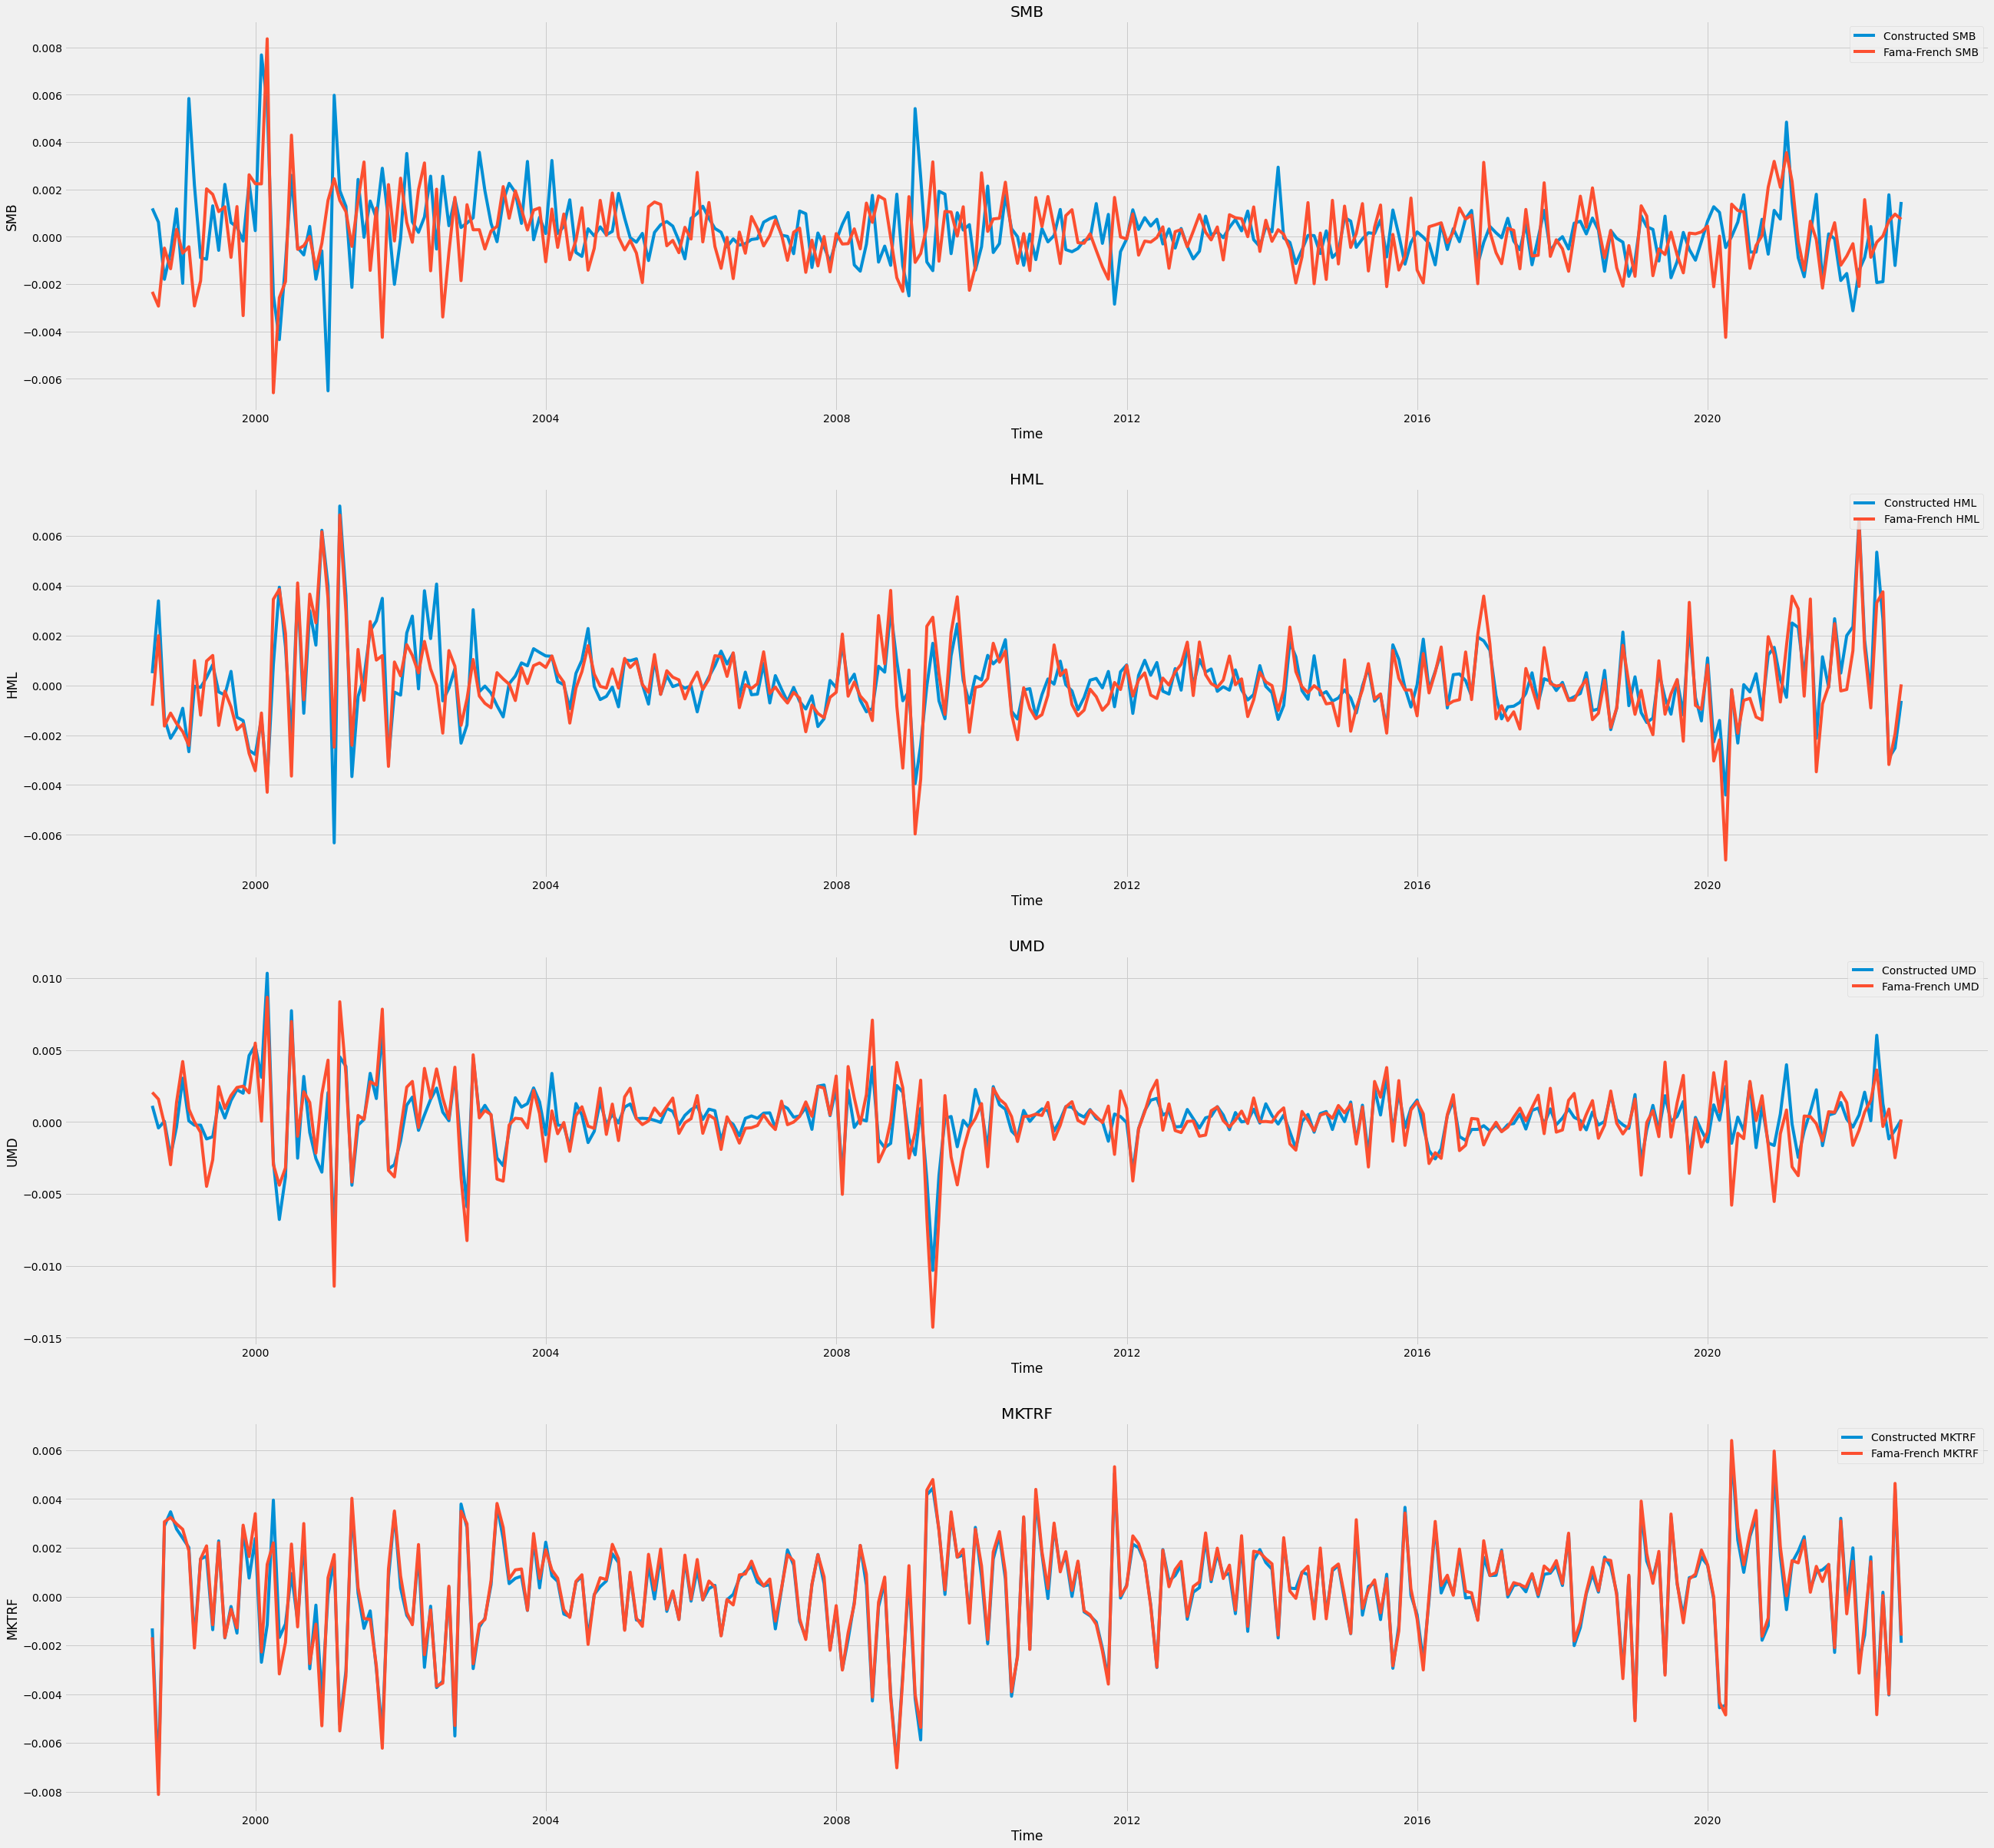

In [47]:
# Plot all factors against each other
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(40, 40))

axs = (ax1, ax2, ax3, ax4)
factors = ["SMB", "HML", "UMD", "MKTRF"]
for i in range(len(axs)):
    ax = (ax1, ax2, ax3, ax4)[i]
    factor = factors[i]

    rms = mean_squared_error(ff_wrds[factor.lower()], df_factors[factor], squared=False)
    print(factor + " RMSE: " + str(rms))

    ax.plot(df_factors[factor].resample('1M').mean(), label="Constructed " + factor)
    ax.plot(ff_wrds[factor.lower()].resample('1M').mean(), label="Fama-French " + factor)
    ax.title.set_text(factor)
    ax.set(xlabel='Time', ylabel=factor)
    ax.legend(loc="upper right")




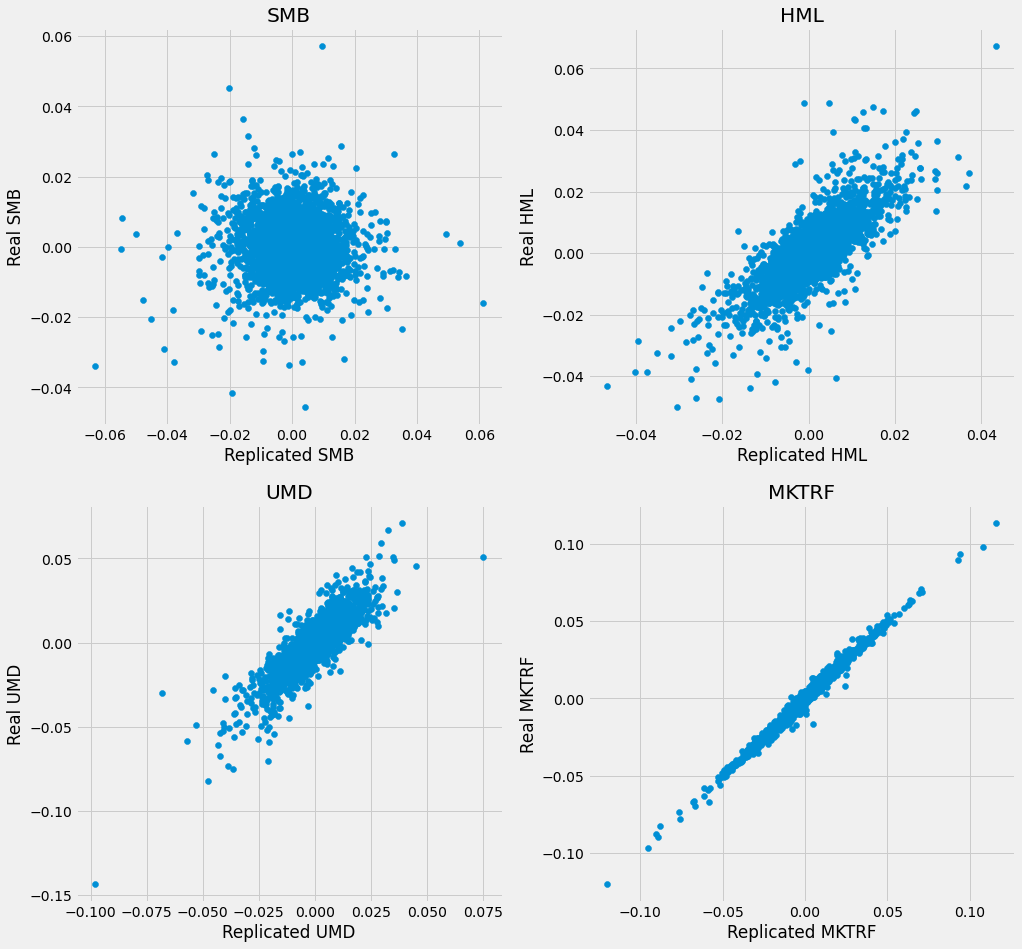

In [48]:
# Find if factors are linear if plotted against each other; linear = perfect
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
factors = ["SMB", "HML", "UMD", "MKTRF"]
factor_count = 0
for i in range(len(axes)):
    row = axes[i]
    for j in range(len(row)):
        col = row[j]
        factor = factors[factor_count]
        col.scatter(df_factors[factor], ff_wrds[factor.lower()])
        col.title.set_text(factor)
        col.set(xlabel='Replicated ' + factor, ylabel="Real " + factor)
        factor_count+=1

In [49]:
# Find the added benefit of momentum factor
X = ff_wrds[["smb", "hml", 'mktrf']]
y = df_factors["UMD"]

X_sm = sm.add_constant(X)
model = sm.OLS(y,X_sm)
results = model.fit()
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    UMD   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     220.1
Date:                Wed, 19 Oct 2022   Prob (F-statistic):          1.47e-135
Time:                        22:07:00   Log-Likelihood:                 21267.
No. Observations:                6082   AIC:                        -4.253e+04
Df Residuals:                    6078   BIC:                        -4.250e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   9.41e-05      2.544      0.011    5.49e-05       0.000
smb            0.1017      0.015      6.856      0.000       0.073       0.131
hml           -0.3002      0.012    -24.660      0.000      -0.324      -0.276
mktrf         -0.0521      0.007     -6.958      0.000      -0.067      -0.037
==============================================================================
Omnibus:                     1438.154   Durbin-Watson:                   1.643
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22232.965
Skew:                          -0.708   Prob(JB):                         0.00
Kurtosis:                      12.259   Cond. No.                         161.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
# Find the added benefit of dividend yield factor
X = ff_wrds[["smb", "hml", 'mktrf']]
y = df_factors["PMR"]

X_sm = sm.add_constant(X)
model = sm.OLS(y,X_sm)
results = model.fit()
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PMR   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     2809.
Date:                Wed, 19 Oct 2022   Prob (F-statistic):               0.00
Time:                        22:07:03   Log-Likelihood:                 24642.
No. Observations:                6082   AIC:                        -4.928e+04
Df Residuals:                    6078   BIC:                        -4.925e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002    5.4e-05     -4.569      0.000      -0.000      -0.000
smb           -0.3215      0.009    -37.753      0.000      -0.338      -0.305
hml            0.5193      0.007     74.311      0.000       0.506       0.533
mktrf         -0.1851      0.004    -43.085      0.000      -0.194      -0.177
==============================================================================
Omnibus:                      593.937   Durbin-Watson:                   1.753
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3641.650
Skew:                           0.250   Prob(JB):                         0.00
Kurtosis:                       6.758   Cond. No.                         161.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
# Get slope of one factor to see if 1
X = ff_wrds[["mktrf"]]
y = df_factors["MKTRF"]

X_sm = sm.add_constant(X)
model = sm.OLS(y,X_sm)
results = model.fit()
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  MKTRF   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 4.857e+05
Date:                Wed, 19 Oct 2022   Prob (F-statistic):               0.00
Time:                        22:07:04   Log-Likelihood:                 31385.
No. Observations:                6082   AIC:                        -6.277e+04
Df Residuals:                    6080   BIC:                        -6.275e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.072e-05   1.78e-05     -4.530      0.000      -0.000   -4.58e-05
mktrf          0.9830      0.001    696.955      0.000       0.980       0.986
==============================================================================
Omnibus:                     2358.459   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            94673.423
Skew:                           1.154   Prob(JB):                         0.00
Kurtosis:                      22.190   Cond. No.                         79.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
# Function to run Fama French Regression on any security
def run_reg(symbol, factors, vars):
    example = get_data(symbol)
    example.index = pd.to_datetime(example.index)
    close_prices = example[["Adj Close"]]
    close_prices["return"] = close_prices['Adj Close'].pct_change()
    close_prices = close_prices[1:]
    close_prices.index = close_prices.index.date
    ff_example = pd.merge(factors, close_prices[["return"]],left_index=True, right_index=True)
    ff_example["sec-rf"] = ff_example['return'] - ff_example["rf"]
    y = ff_example["sec-rf"]
    try:
        X = ff_example[vars]
    except KeyError:
        X = ff_example[[x.lower() for x in vars]]
    X_sm = sm.add_constant(X)
    model = sm.OLS(y,X_sm)
    results = model.fit()
    display(results.summary())

In [53]:
# Compare regression outputs given constructed factors and real factors for a fund
vars = ["SMB","HML","UMD", "MKTRF"]
#vars = ["UMD"]
run_reg("AXVNX", df_factors, vars)
run_reg("AXVNX", ff_wrds, vars)

[*********************100%***********************]  1 of 1 completed


/var/folders/m6/h9jtrhyn259fytxp6j9xh9v00000gn/T/ipykernel_7391/1046405478.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_prices["return"] = close_prices['Adj Close'].pct_change()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 sec-rf   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     919.7
Date:                Wed, 19 Oct 2022   Prob (F-statistic):          1.42e-318
Time:                        22:07:06   Log-Likelihood:                 3047.2
No. Observations:                 919   AIC:                            -6084.
Df Residuals:                     914   BIC:                            -6060.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.000     -0.400      0.689      -0.001       0.000
SMB            0.5607      0.056     10.100      0.000       0.452       0.670
HML            0.8329      0.035     24.008      0.000       0.765       0.901
UMD           -0.2497      0.026     -9.482      0.000      -0.301      -0.198
MKTRF          1.2909      0.025     51.420      0.000       1.242       1.340
==============================================================================
Omnibus:                      114.929   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              712.975
Skew:                           0.365   Prob(JB):                    1.51e-155
Kurtosis:                       7.253   Cond. No.                         210.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

[*********************100%***********************]  1 of 1 completed


/var/folders/m6/h9jtrhyn259fytxp6j9xh9v00000gn/T/ipykernel_7391/1046405478.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_prices["return"] = close_prices['Adj Close'].pct_change()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 sec-rf   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                 1.128e+04
Date:                Wed, 19 Oct 2022   Prob (F-statistic):               0.00
Time:                        22:07:06   Log-Likelihood:                 4106.2
No. Observations:                 919   AIC:                            -8202.
Df Residuals:                     914   BIC:                            -8178.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.694e-05   9.19e-05      0.620      0.536      -0.000       0.000
smb            0.8264      0.013     65.607      0.000       0.802       0.851
hml            0.5375      0.009     63.230      0.000       0.521       0.554
umd           -0.0194      0.007     -2.685      0.007      -0.034      -0.005
mktrf          1.0102      0.006    155.920      0.000       0.997       1.023
==============================================================================
Omnibus:                      158.744   Durbin-Watson:                   2.209
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2832.757
Skew:                          -0.085   Prob(JB):                         0.00
Kurtosis:                      11.599   Cond. No.                         142.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
# Same thing for single company
vars = ["SMB","HML","UMD", "MKTRF"]
#vars = ["UMD"]
run_reg("MSFT", df_factors, vars)
run_reg("MSFT", ff_wrds, vars)


[*********************100%***********************]  1 of 1 completed


/var/folders/m6/h9jtrhyn259fytxp6j9xh9v00000gn/T/ipykernel_7391/1046405478.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_prices["return"] = close_prices['Adj Close'].pct_change()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 sec-rf   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     1627.
Date:                Wed, 19 Oct 2022   Prob (F-statistic):               0.00
Time:                        22:07:08   Log-Likelihood:                 17461.
No. Observations:                6082   AIC:                        -3.491e+04
Df Residuals:                    6077   BIC:                        -3.488e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      2.281      0.023    5.66e-05       0.001
SMB           -0.0087      0.038     -0.229      0.819      -0.083       0.066
HML           -0.4693      0.033    -14.332      0.000      -0.533      -0.405
UMD            0.0929      0.024      3.928      0.000       0.047       0.139
MKTRF          1.0528      0.023     45.172      0.000       1.007       1.098
==============================================================================
Omnibus:                     1271.878   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45985.791
Skew:                          -0.149   Prob(JB):                         0.00
Kurtosis:                      16.468   Cond. No.                         259.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

[*********************100%***********************]  1 of 1 completed


/var/folders/m6/h9jtrhyn259fytxp6j9xh9v00000gn/T/ipykernel_7391/1046405478.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_prices["return"] = close_prices['Adj Close'].pct_change()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 sec-rf   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     1786.
Date:                Wed, 19 Oct 2022   Prob (F-statistic):               0.00
Time:                        22:07:08   Log-Likelihood:                 17611.
No. Observations:                6082   AIC:                        -3.521e+04
Df Residuals:                    6077   BIC:                        -3.518e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.749      0.080   -3.63e-05       0.001
smb           -0.3182      0.027    -11.756      0.000      -0.371      -0.265
hml           -0.4570      0.024    -19.084      0.000      -0.504      -0.410
umd           -0.0354      0.018     -1.968      0.049      -0.071      -0.000
mktrf          1.1091      0.014     78.739      0.000       1.081       1.137
==============================================================================
Omnibus:                     1321.340   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            53252.109
Skew:                          -0.163   Prob(JB):                         0.00
Kurtosis:                      17.492   Cond. No.                         165.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""